# Task 1

## Setting up the notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import random
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,RidgeCV, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate

%matplotlib inline
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

## 1. Data Preparation

### 1.1 Loading the Data
Load the train data set

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,73000.0,45330.0,50462.0,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,71300.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,110112.0,27502.0,1376.0,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,43800.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,80000.0,27886.0,26041.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,95500.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,9800.0,46412.0,56977.0,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,197900.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,40000.0,20072.0,20101.0,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,103200.0


In [3]:
num_points, num_attributes = df.shape

print("There are {} data points, each with {} attributes.". format(num_points, num_attributes))

There are 16784 data points, each with 30 attributes.


In [4]:
df.dtypes 

listing_id             int64
title                 object
make                  object
model                 object
description           object
manufactured         float64
original_reg_date     object
reg_date              object
type_of_vehicle       object
category              object
transmission          object
curb_weight          float64
power                float64
fuel_type             object
engine_cap           float64
no_of_owners         float64
depreciation         float64
coe                  float64
road_tax             float64
dereg_value          float64
mileage              float64
omv                  float64
arf                  float64
opc_scheme            object
lifespan              object
eco_category          object
features              object
accessories           object
indicative_price     float64
price                float64
dtype: object

In [5]:
col_cat = df.dtypes[df.dtypes=='object'].index
col_num = df.dtypes[(df.dtypes=='int64') | (df.dtypes=='float64')].index

In [6]:
# to display all the categorical columns
col_cat 

Index(['title', 'make', 'model', 'description', 'original_reg_date',
       'reg_date', 'type_of_vehicle', 'category', 'transmission', 'fuel_type',
       'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories'],
      dtype='object')

In [7]:
# to display all the numerical columns
col_num 

Index(['listing_id', 'manufactured', 'curb_weight', 'power', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'indicative_price', 'price'],
      dtype='object')

In [8]:
# to summarize the numerical data
df.describe()

,listing_id,manufactured,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,indicative_price,price
count,1.678400e+04,16590.000000,16205.000000,14447.000000,16731.000000,16608.000000,16351.000000,15893.000000,14630.000000,15595.000000,13060.000000,1.674300e+04,16500.000000,0.0,1.678400e+04
mean,1.009717e+06,2014.212417,1554.616230,133.950647,2086.423944,2.033297,14489.055104,41336.704524,1358.951880,44208.937865,72539.375651,3.896792e+04,38636.758242,NaN,1.129102e+05
std,2.644722e+04,8.771572,820.442216,74.294299,1126.062034,1.362351,19367.989982,16553.755676,1187.558721,42816.473242,50985.924208,4.445251e+04,59749.028200,NaN,1.342478e+05
min,3.652410e+05,1933.000000,2.000000,40.500000,0.000000,1.000000,2680.000000,10.000000,50.000000,97.000000,1.000000,8.880000e+02,63.000000,NaN,2.100000e+03
25%,1.002488e+06,2011.000000,1280.000000,90.000000,1497.000000,1.000000,8630.000000,31335.000000,684.000000,24985.000000,32661.500000,1.919300e+04,12614.250000,NaN,5.700000e+04
50%,1.017508e+06,2016.000000,1440.000000,110.000000,1797.000000,2.000000,10610.000000,40512.000000,976.000000,35556.000000,65801.500000,2.708400e+04,21698.000000,NaN,8.010000e+04
75%,1.025184e+06,2018.000000,1680.000000,147.000000,2356.000000,3.000000,14870.000000,51600.000000,1369.000000,50403.500000,104000.000000,4.068750e+04,42642.750000,NaN,1.209250e+05
max,1.031324e+06,2925.000000,20980.000000,552.000000,15681.000000,6.000000,865610.000000,97889.000000,12375.000000,653862.000000,740459.000000,1.150000e+06,858230.000000,NaN,2.920500e+06


## 2. Exploratory Data Analysis

### 2.1 Missing values

First to find all rows that have at least 1 NA value in any column.
- Finding: all the rows contains at least 1 empty entry

In [9]:
row_has_na = df.isna().any(axis=1)

df_na = df[row_has_na]

print("There are {} data points that have at least 1 missing value (NA)".format(df_na.shape[0]))

There are 16784 data points that have at least 1 missing value (NA)


### 2.2 Check for Collinearity

- Drop the `indicative_price` column as it has all NA rows
- Filter the numerical features

In [10]:
col_num =df.dtypes[(df.dtypes=='int64') | (df.dtypes=='float64')].index 
col_num = list(col_num)
col_num.remove('indicative_price')
len(col_num)

14

Display the numeric features

In [11]:
col_num

['listing_id',
 'manufactured',
 'curb_weight',
 'power',
 'engine_cap',
 'no_of_owners',
 'depreciation',
 'coe',
 'road_tax',
 'dereg_value',
 'mileage',
 'omv',
 'arf',
 'price']

#### 2.2.1 Plot the distribution of all the numeric features


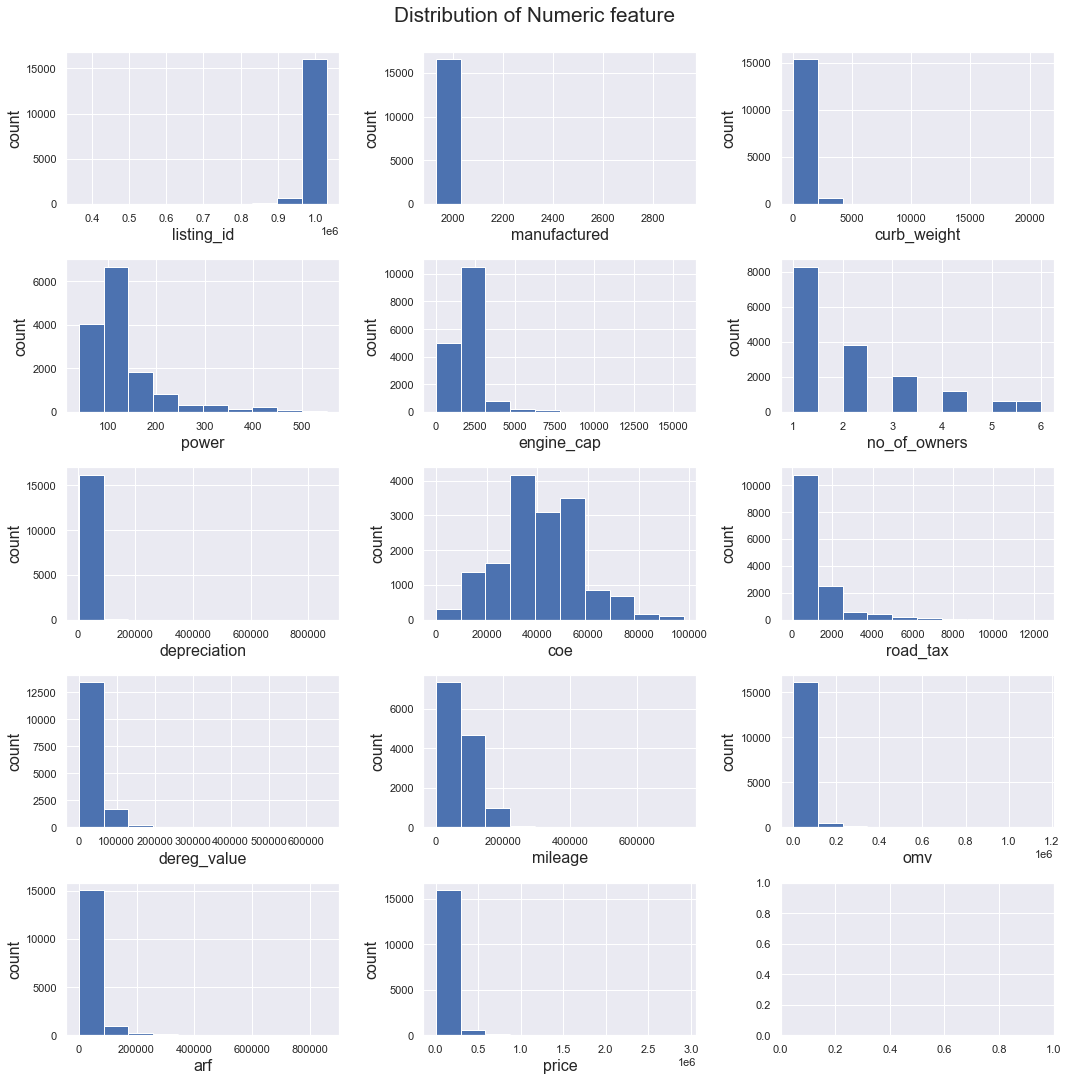

In [12]:
fig, axs = plt.subplots(5, 3, figsize=(15,15))
rowPosn = 0
colPosn = 0

def addPosn():
    global colPosn
    colPosn+=1
    if colPosn > 2:
        colPosn = 0
        global rowPosn
        rowPosn+=1
    
for col in col_num:
    axs[rowPosn,colPosn].hist(df[col])
    axs[rowPosn,colPosn].set_xlabel(col, fontsize=16)
    axs[rowPosn,colPosn].set_ylabel('count', fontsize=16)
    addPosn()

fig.suptitle("Distribution of Numeric feature", y=1, fontsize='xx-large')
fig.tight_layout()

#### 2.2.2 To plot the heatmap for correlation

<AxesSubplot:>

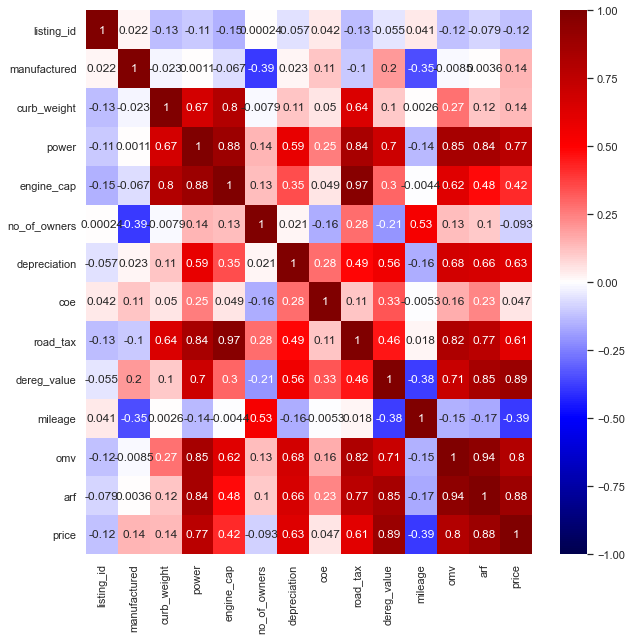

In [13]:
df_col_num = df[col_num]
f, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(df_col_num.corr(), cmap='seismic', vmin=-1, vmax=1, annot=True)


#### 2.2.3 To show all the feature pairs with collinearity >0.8
Create functions to rank top collinearities, ref: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas.

We can see that: collinearity: R2>0.9
- `omv`~`arf`: 0.938438
- `road_tax`~`engine_cap`: 0.966132


In [14]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[(au_corr>0.8)]


In [15]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_col_num ))

Top Absolute Correlations
engine_cap   road_tax      0.966132
omv          arf           0.938438
dereg_value  price         0.894838
power        engine_cap    0.884905
arf          price         0.884832
power        omv           0.849986
dereg_value  arf           0.849308
power        arf           0.843883
             road_tax      0.842316
road_tax     omv           0.816899
omv          price         0.804580
dtype: float64


## 3. Regression Model

### 3.1 Split train data and validation data

- on 80% train, 20% validation basis

In [16]:
rng = 0
df = pd.read_csv('data/train.csv',index_col=0)
X = df.drop('price', axis=1)
Y = df.price

X_train, X_htest, Y_train, Y_htest = train_test_split(X, Y, test_size=0.2, random_state=rng)

In [17]:
X_train.columns

Index(['title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price'],
      dtype='object')

- To display the numeric columns

In [18]:
#numeric columns
X_train.columns[X_train.dtypes=='float64']

Index(['manufactured', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
       'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv',
       'arf', 'indicative_price'],
      dtype='object')

- To display the categorical columns

In [19]:
#cat columns
X_train.columns[X_train.dtypes=='object']

Index(['title', 'make', 'model', 'description', 'original_reg_date',
       'reg_date', 'type_of_vehicle', 'category', 'transmission', 'fuel_type',
       'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories'],
      dtype='object')

In [20]:
X_train.describe()

,manufactured,curb_weight,power,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,indicative_price
count,13279.000000,12959.000000,11558.000000,13383.000000,13297.000000,13087.000000,12708.000000,11702.000000,12476.000000,10418.000000,13394.000000,13203.000000,0.0
mean,2014.194292,1555.412223,134.287005,2088.685347,2.039558,14546.417055,41381.010545,1366.281405,43960.244229,72852.654636,38974.800284,38643.081875,NaN
std,9.474873,816.127944,74.191856,1116.929951,1.364442,19684.905787,16565.523474,1196.465232,41846.966908,51252.773713,43604.756752,59029.332795,NaN
min,1933.000000,2.000000,40.500000,0.000000,1.000000,2680.000000,10.000000,50.000000,97.000000,1.000000,888.000000,90.000000,NaN
25%,2011.000000,1280.000000,90.000000,1498.000000,1.000000,8630.000000,31335.000000,684.000000,24913.000000,32794.750000,19211.250000,12653.000000,NaN
50%,2016.000000,1440.000000,110.000000,1797.000000,2.000000,10630.000000,40523.500000,976.000000,35621.000000,66000.000000,27131.000000,21886.000000,NaN
75%,2018.000000,1680.000000,147.000000,2359.000000,3.000000,14900.000000,51600.000000,1417.000000,50322.000000,105000.000000,40858.750000,42668.000000,NaN
max,2925.000000,18520.000000,552.000000,15681.000000,6.000000,865610.000000,97889.000000,12375.000000,653862.000000,740459.000000,592131.000000,858230.000000,NaN


### 3.2 Check for number of missing values

- to show the percentage of null in each feature
- we can see here that `original_reg_date`, `fuel_type`, `opc_scheme`, `lifespan`, `indicative_price` are with high percentage of empty entry

In [21]:
X_train.apply(lambda x: sum(x.isnull()))/X_train.shape[0]

title                0.000000
make                 0.129813
model                0.000000
description          0.020332
manufactured         0.011023
original_reg_date    0.981157
reg_date             0.011395
type_of_vehicle      0.000000
category             0.000000
transmission         0.000000
curb_weight          0.034855
power                0.139197
fuel_type            0.791465
engine_cap           0.003277
no_of_owners         0.009682
depreciation         0.025322
coe                  0.053549
road_tax             0.128472
dereg_value          0.070827
mileage              0.224101
omv                  0.002458
arf                  0.016683
opc_scheme           0.988158
lifespan             0.899233
eco_category         0.000000
features             0.027110
accessories          0.168839
indicative_price     1.000000
dtype: float64

### 3.3 Feature selection

**Features to keep:**

numerical columns:
- `manufactured`
- `curb_weight`
- `power`
- `engine_cap` 
- `no_of_owners`
- `depreciation` 
- `coe`
- `dereg_value`
- `mileage`
- `omv`
- `reg_date_processed` (to be created)

categorical columns:
- `type_of_vehicle`
- `transmission`
- `manufacturer`(to be created)


**Feathures to drop:**
- `omv` &`arf`: as a new feature `ARF_calculated` is created
- `road_tax`: as collinear with `engine_cap`
- `model`: categorical feature contains 692 unique values that not helpful for regression 
- `title`: categorical feature contains 5775 unique values that not helpful for regression
- `make`: new feature `manufacturer`will be created to replace `make`
- `description`: drop as too much content that requires further processing. 
- `original_reg_date`: drop as new feature `reg_date_processed` is created
- `reg_date`: drop as new feature `reg_date_processed` is created
- `category`: drop as too much content that requires further processing.
- `fuel_type`: 79% are null
- `opc_scheme`: 99% are null
- `lifespan`: 90% are null
- `eco_category`: only 1 unique value, not meaningful
- `features`: drop as too much content that requires further processing.
- `accessories`: drop as too much content that requires further processing.
- `indicative_price`: 100% are null

### 3.4 Feature creation
- Creat a custom FeatureCreator for creating new features
- `ARF_calculated`: is created based on the `omv` and `arf`, that the missing vaule in `arf` is filled based on following calculation with reference from: https://www.sgcarmart.com/news/writeup.php?AID=13
    - For cars with an `omv` of up to 20,000: `arf` = `omv`
    - For cars with an `omv` ranging from 20,001 to 50,000: `arf` = [(`omv` - 20,000) x 140%] + 20,000
    - For cars with an `omv` above 50,000: `arf` = [(`omv` - 50,000) x 180%] + 62,000
- It is observed that `original_reg_date` and `reg_date` can be merged together, as for all rows with missing values in `reg_date`, we can fill it with `original_reg_date`. `reg_date_processed` is created for the merge.
- Also as `reg_date_processed` is in datetime format, it can not be processed in the sklearn pipeline, we will convert it to the date_count till today (4-Oct-2021).
- It's also notised that the `make` column has some missing values, but the first word of the `title` serves the same funtion, so we will just parse `title` and use the first word to create a new feature `manufacturer`


In [22]:
class FeatureCreator(BaseEstimator,TransformerMixin):
    def __init__(self):
        return
        
    def fit(self, X, y=None, **fit_params):
        return self
        
    def transform(self, X, y=None, **fit_params):
        self.X = X.copy()

        self.X['reg_date_processed'] = np.where(self.X['reg_date'].isnull(), self.X['original_reg_date'],self.X['reg_date'] )            
        
        self.X['reg_date_processed'] = pd.to_datetime("4-Oct-2021").date() - pd.to_datetime(self.X['reg_date_processed']).dt.date
        self.X['reg_date_processed'] = self.X['reg_date_processed'].dt.days/365
        
        conditions = [
            self.X['omv'] <= 20000,
            (self.X['omv'] > 20000) & (self.X['omv'] <=50000),
            self.X['omv'] > 50000
        ]

        values = [
            self.X['omv'],
            ((self.X['omv']-20000)*1.4+20000),
            ((self.X['omv']-50000)*1.8+62000)
        ]

        self.X['ARF_calculated'] = np.select(conditions, values, default=0)
        
        self.X['ARF_calculated'] = np.where(self.X['arf'].isnull(), self.X['ARF_calculated'],self.X['arf'] ) 
        
        self.X['manufacturer'] = self.X['title'].str.split().str[0]

        return self.X 

In [23]:
###test
fc = FeatureCreator()
test = fc.fit_transform(df)
test.head()

,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,...,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price,reg_date_processed,ARF_calculated,manufacturer
listing_id,,,,,,,,,,,,,,,,,,,,,
1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",auto,...,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,71300.0,7.824658,50462.0,BMW
1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,manual,...,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,43800.0,6.693151,1376.0,Toyota
1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",auto,...,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,95500.0,5.197260,26041.0,Mercedes-Benz
1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",auto,...,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,197900.0,0.879452,56977.0,Mercedes-Benz
1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,auto,...,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,103200.0,2.041096,20101.0,Honda


### 3.5 Create imputor and encoder

In [24]:
#create imputers
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy="most_frequent")

#create transformers
cat_enc = OneHotEncoder(handle_unknown='ignore')

#create encoders
num_encoder = num_imp
cat_encoder = Pipeline(steps=[('cat_imp', cat_imp), ('cat_enc', cat_enc)])


In [25]:
from sklearn import compose

num_cols = ['manufactured', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
            'depreciation', 'coe','dereg_value', 'mileage','reg_date_processed','ARF_calculated']
# cat_cols = [ 'type_of_vehicle', 'transmission', 'manufacturer']

coltfr = compose.ColumnTransformer(
                transformers=[
                    ('num', num_encoder, num_cols),
#                     ('cat', cat_encoder, cat_cols),
                ], remainder ='drop')
                
preprocessor = Pipeline(steps=[
    ('featcreate', FeatureCreator()),
    ('colproc', coltfr)
])

In [26]:
X_train.shape

(13427, 28)

In [27]:
X_procd = preprocessor.fit_transform(X_train, Y_train)
X_procd.shape

(13427, 11)

### 3.6 Create the pipelines for 4 different basic estimators
- Linear regression
- RidgeCV
- Decision tree
- KNN

In [28]:
est1 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regression', LinearRegression())])
est2 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regression', RidgeCV(cv=5))])
est3 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regression', DecisionTreeRegressor(random_state =0))])
est4 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regression', KNeighborsRegressor())])


### 3.7 To fit the estimators and check the performance metics
- Intorducing 5 folds cross validation on the train data

**Finding:**

- Slightly overfitting can be seen here as RMSE_validation is higher than RMSE_training 

In [29]:
i=0
for est in [est1, est2, est3,est4]:

    
    # Perform 5-fold cross_validations
    scores = cross_validate(est, X_train, Y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
    RMSE_train = scores['train_score'] * (-1)
    RMSE_valid = scores['test_score'] * (-1)
    
    i+=1
    print('est {}, RMSE training = {:6.0f} ({:6.0f}), RMSE validation = {:6.0f} ({:6.0f})'
          .format(i, np.mean(RMSE_train), np.std(RMSE_train), np.mean(RMSE_valid), np.std(RMSE_valid)))

est 1, RMSE training =  51786 (  1514), RMSE validation =  55737 (  9045)
est 2, RMSE training =  51786 (  1514), RMSE validation =  55732 (  9038)
est 3, RMSE training =      0 (     0), RMSE validation =  43153 (  4096)
est 4, RMSE training =  31147 (  1691), RMSE validation =  37968 (  6220)


### 3.8 Move on to add the feature selection into the pipeline, and also introuducing the ensamble regressors
- Add feature slection: SelectKBest(), choose k=11 for 11 best features
- Add standardization, StandardScaler() / MinMaxScaler() 
- redo 5 folds cross validation on the train data

**Finding:**
- `est4_new`, `est5_new` and `est7_new` have better performance.
- Further fine tunning on the hyper parameter could be done
- StandardScaler() shows better result compared to MinMaxScaler, hence to choose StandardScaler()

In [30]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer, MinMaxScaler


# to perform the feature selection

scaler = StandardScaler(with_mean=False)
# scaler = MinMaxScaler()

k =11

est1_new = Pipeline(steps=[('preprocessor', preprocessor),('scaler',scaler),
                           ('feature_sel',SelectKBest(score_func=f_regression, k=k)),
                       ('regression', LinearRegression())])

est2_new = Pipeline(steps=[('preprocessor', preprocessor),('scaler',scaler),
                           ('feature_sel',SelectKBest(score_func=f_regression, k=k)),
                       ('regression', RidgeCV(cv=5))])

est3_new = Pipeline(steps=[('preprocessor', preprocessor),('scaler',scaler),
                           ('feature_sel',SelectKBest(score_func=f_regression, k=k)),
                       ('regression', DecisionTreeRegressor(random_state =0))])

est4_new = Pipeline(steps=[('preprocessor', preprocessor),('scaler',scaler),
                           ('feature_sel',SelectKBest(score_func=f_regression, k=k)),
                       ('regression', KNeighborsRegressor(n_neighbors=3))])

est5_new = Pipeline(steps=[('preprocessor', preprocessor),('scaler',scaler),
                           ('feature_sel',SelectKBest(score_func=f_regression, k=k)),
                       ('regression', RandomForestRegressor(random_state =0, 
                                                            n_estimators =20))])

est6_new = Pipeline(steps=[('preprocessor', preprocessor),('scaler',scaler),
                           ('feature_sel',SelectKBest(score_func=f_regression, k=k)),
                       ('regression', AdaBoostRegressor(random_state =0 ))])

est7_new = Pipeline(steps=[('preprocessor', preprocessor),('scaler',scaler),
                           ('feature_sel',SelectKBest(score_func=f_regression, k=k)),
                       ('regression', GradientBoostingRegressor(random_state =0 ))])


In [31]:
i=0
for est in [est1_new, est2_new, est3_new, est4_new, est5_new, est6_new, est7_new]:

    
    # Perform 10-fold cross_validations
    scores = cross_validate(est, X_train, Y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
    RMSE_train = scores['train_score'] * (-1)
    RMSE_valid = scores['test_score'] * (-1)
    
    i+=1
    print('est {}, RMSE training = {:6.0f} ({:6.0f}), RMSE validation = {:6.0f} ({:6.0f})'
          .format(i, np.mean(RMSE_train), np.std(RMSE_train), np.mean(RMSE_valid), np.std(RMSE_valid)))

est 1, RMSE training =  51786 (  1514), RMSE validation =  55737 (  9045)
est 2, RMSE training =  51787 (  1514), RMSE validation =  55620 (  8885)
est 3, RMSE training =      0 (     0), RMSE validation =  43151 (  4093)
est 4, RMSE training =  23438 (  2160), RMSE validation =  34711 (  6881)
est 5, RMSE training =  12138 (   775), RMSE validation =  28132 (  8291)
est 6, RMSE training = 106705 ( 35119), RMSE validation = 111090 ( 30627)
est 7, RMSE training =  19813 (   274), RMSE validation =  31909 (  6979)


### 3.9 To test the select `est4_new`,`est5_new`, `est7_new`on the hold out data
- `est5_new` is selected as the final estimator for the regression model based on the low RMSE result

**To test the model on hold out set: est4_new**

In [32]:
#X_train, X_htest, Y_train, Y_htest
est4_new.fit(X_train, Y_train )

Y_prd = est4_new.predict(X_htest)
    
print('RMSE test est4_new={:.01f}'.format(mean_squared_error(Y_htest, Y_prd)**0.5))
print('R2 test est4_new ={}'.format( r2_score(Y_htest, Y_prd)))


RMSE test est4_new=39052.7
R2 test est4_new =0.927473901823418


**To test the model on hold out set: est5_new**

In [33]:
#X_train, X_htest, Y_train, Y_htest
est5_new.fit(X_train, Y_train )

Y_prd = est5_new.predict(X_htest)
    
print('RMSE test est5_new={:.01f}'.format(mean_squared_error(Y_htest, Y_prd)**0.5))
print('R2 test est5_new ={}'.format( r2_score(Y_htest, Y_prd)))


RMSE test est5_new=30707.1
R2 test est5_new =0.955159593897666


**To test the model on hold out set: est7_new**

In [34]:
#X_train, X_htest, Y_train, Y_htest
est7_new.fit(X_train, Y_train )

Y_prd = est7_new.predict(X_htest)

    
print('RMSE test est7_new={:.01f}'.format(mean_squared_error(Y_htest, Y_prd)**0.5))
print('R2 test est7_new ={}'.format( r2_score(Y_htest, Y_prd)))

RMSE test est7_new=33889.0
R2 test est7_new =0.9453851423252817


### 3.10 Plot out the Y_htest vs Y_prd
- using finalized `est5_new`

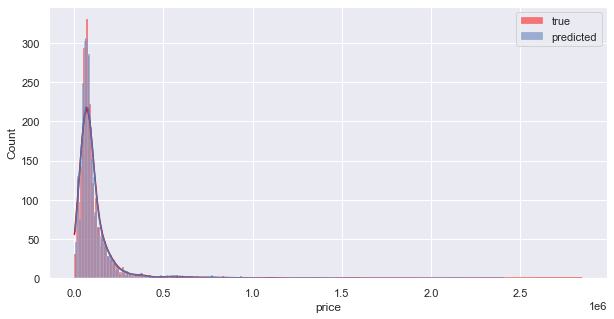

In [35]:
f, axs = plt.subplots(1, 1, figsize=(10, 5))
est5_new.fit(X_train, Y_train)
Y_prd =est5_new.predict(X_htest)

sns.histplot(Y_htest, label='true', color='red', kde=True)
sns.histplot(Y_prd, label='predicted', kde=True)
plt.legend()

### 3.11 Grid Search
Grid search on finalized `est5_new`: random forest regressor:

In [36]:
est5_new = Pipeline(steps=[('preprocessor', preprocessor),('feature_sel',SelectKBest(score_func=f_regression, k=11)),
                       ('regression', RandomForestRegressor(random_state =0, n_estimators =20))])
# est5_new.get_params()

In [37]:
hps = {'preprocessor__colproc__num__strategy': ['mean', 'median'], 
#                'feature_sel__k':[i for i in range(20,40)],
               'feature_sel__k':[5,8,11],
               'regression__n_estimators': [20,40,80],
      'regression__max_depth':[3,10,None]}

In [38]:
%%time
est = GridSearchCV(est5_new, hps, cv=5, scoring="neg_mean_squared_error")
est.fit(X, Y)
optimal_est = est.best_estimator_

Wall time: 19min 8s


In [39]:
print(est.best_params_)

{'feature_sel__k': 11, 'preprocessor__colproc__num__strategy': 'mean', 'regression__max_depth': None, 'regression__n_estimators': 40}


In [40]:
optimal_est = Pipeline(steps=[('preprocessor', preprocessor),('feature_sel',SelectKBest(score_func=f_regression, k=11)),
                       ('regression', RandomForestRegressor(random_state =0, n_estimators =40,max_depth = None ))])

Feature: 0, Score: 0.00444 manufactured
Feature: 1, Score: 0.01027 curb_weight
Feature: 2, Score: 0.00688 power
Feature: 3, Score: 0.01924 engine_cap
Feature: 4, Score: 0.00127 no_of_owners
Feature: 5, Score: 0.03573 depreciation
Feature: 6, Score: 0.01195 coe
Feature: 7, Score: 0.05607 dereg_value
Feature: 8, Score: 0.01049 mileage
Feature: 9, Score: 0.08418 reg_date_processed
Feature: 10, Score: 0.75948 ARF_calculated


[Text(0, 0, 'manufactured'),
 Text(1, 0, 'curb_weight'),
 Text(2, 0, 'power'),
 Text(3, 0, 'engine_cap'),
 Text(4, 0, 'no_of_owners'),
 Text(5, 0, 'depreciation'),
 Text(6, 0, 'coe'),
 Text(7, 0, 'dereg_value'),
 Text(8, 0, 'mileage'),
 Text(9, 0, 'reg_date_processed'),
 Text(10, 0, 'ARF_calculated')]

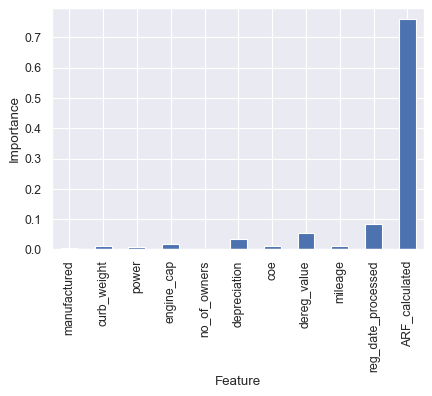

In [41]:
plt.figure(figsize=(6, 4), dpi=80)
cols = ['manufactured', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
            'depreciation', 'coe','dereg_value', 'mileage','reg_date_processed','ARF_calculated']
optimal_est.fit(X, Y)
# get importance
importance = optimal_est.steps[2][1].feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v),cols[i])
    
freq_series = pd.Series(importance)
ax =freq_series.plot(kind='bar')

ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(cols)

## 4. To run the optimized model on entire train data: X,Y

### 4.1 Perform the 10 folds validation on the entire training data with `optimal_est` from grid search

In [42]:
# Perform 10-fold cross_validations
scores = cross_validate(optimal_est, X, Y, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
RMSE_train = scores['train_score'] * (-1)
RMSE_valid = scores['test_score'] * (-1)

print('optimal_est, RMSE training = {:.01f} ({:.01f}), RMSE validation = {:.01f} ({:.01f})'
        .format(np.mean(RMSE_train), np.std(RMSE_train), np.mean(RMSE_valid), np.std(RMSE_valid)))

optimal_est, RMSE training = 11035.3 (327.1), RMSE validation = 28473.2 (5033.9)


### 4.2 To train the `optimal_est` on the entire dataset, and predict on the test data

In [43]:
optimal_est.fit(X, Y)
X_test = pd.read_csv('data/test.csv',index_col=0)

Y_prd =optimal_est.predict(X_test)

submission = pd.read_csv("data/example-submission.csv",
                         index_col=[0])
submission['Predicted'] = Y_prd
submission.to_csv('submission_new_.csv')